# Algorithmic Machine Learning — Project Report  
## Eye Disease Classification
## 👥 Group C

| Name | ID | NetID |
|------|--------|--------|
| **Shashank Kamble** | 668654.0 | sk3369 |
| **Saumya Poojari** | 667617.0 | sp2877 |
| **Jieying Wang** | 684332.0 | jw2088 |
---

**December 2025**

## Abstract

This project builds a multi-class classifier to predict retinal eye disease categories from fundus images.
We construct a clean labeled dataset, extract compact image representations using a pretrained CNN
(MobileNetV2), reduce dimensionality with PCA, and train/evaluate multiple classical machine learning
models (Logistic Regression, SVM, Random Forest, MLP, and XGBoost).

To ensure robustness and reproducibility, we save intermediate artifacts (embeddings and PCA features)
from a development workflow and load them in the main report notebook. In addition to a fixed
train/val/test split, we run a fold-safe cross-validation evaluation using a scikit-learn
Pipeline (imputation → scaling → PCA → classifier).



## 1. Project Overview

The goal of this project is to classify retinal fundus images into one of several disease categories
(multi-class classification). Instead of training a deep CNN end-to-end, we adopt a hybrid pipeline:

- Preprocess and index the full dataset of retinal images.
- Extract fixed-length embeddings using a pretrained MobileNetV2 backbone.
- Standardize and reduce dimensionality using PCA (retain 95% variance).
- Train and compare multiple supervised machine learning models on the PCA-transformed features.

For robustness, we additionally (optionally) evaluate the pipeline using stratified cross-validation
implemented as a scikit-learn Pipeline, which performs preprocessing within each fold and avoids leakage.


## 2. Dataset & Preprocessing Summary

### 2.1 Dataset
We use the **Eye Diseases Classification** dataset from Kaggle, organized in class-specific folders of fundus images.
After scanning all files and verifying readability, we obtained:

- **Total usable images:** 4217  
- **Label source:** folder names → mapped deterministically to integer IDs  
- **Image size range:** 256×256 to 2592×1728 (recorded during inspection)

### 2.2 Preprocessing (What the notebook does)
In Colab, we:
1. Mount Google Drive and read the dataset directory.  
2. Build a dataframe of **(filepath, label)** for every image.  
3. Inspect each image to record **width/height** and drop unreadable files (**0** found).  
4. Create a deterministic `label_map` and encode labels to integer IDs.  
5. Generate **stratified splits** with `random_state=42`:
   - Train: 70%
   - Validation: 15%
   - Test: 15%  
6. Save a merged index CSV (`eye_disease_cleaned.csv`) for reproducibility.



### 2.3 Preprocessing Implementation (Colab)
The following cells implement the preprocessing steps described above (dataframe construction, image inspection,
label encoding, stratified splitting, and saving the cleaned index CSV).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


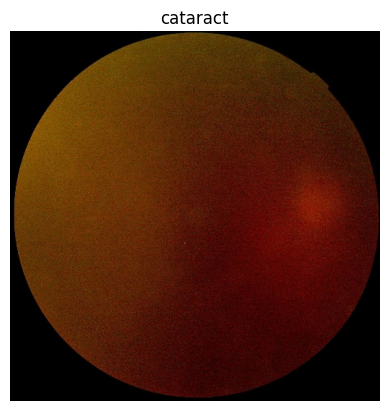

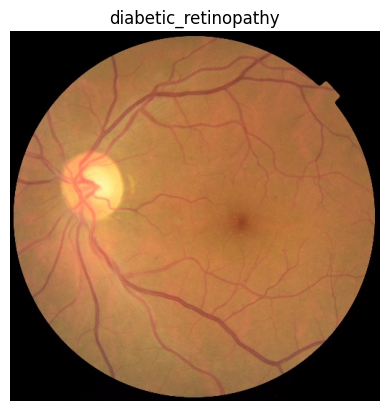

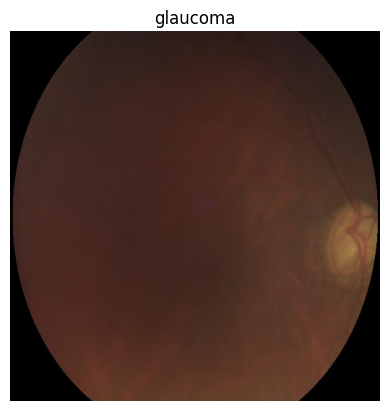

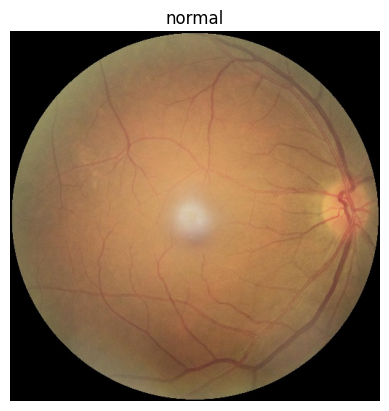

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

root = "/content/drive/MyDrive/AML_Project_EyeDisease/data"

classes = [c for c in os.listdir(root) if not c.startswith(".")]
print("Classes:", classes)

# try to use the path
for cls in classes:
    class_dir = os.path.join(root, cls)
    files = [f for f in os.listdir(class_dir) if not f.startswith(".")]
    if len(files) == 0:
        print(f"No files found in {class_dir}")
        continue
    img_path = os.path.join(class_dir, files[0])
    img = Image.open(img_path)

    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
    plt.show()

In [ ]:
# create a dataframe(filepath + label)
rows = []

for cls in classes:
    class_dir = os.path.join(root,cls)
    files = [f for f in os.listdir(class_dir) if not f.startswith(".")]
    for fname in files:
        fpath = os.path.join(class_dir, fname)
        rows.append({
            "filepath": fpath,
            "label": cls
        })

df = pd.DataFrame(rows)
print("Total images:", len(df))
df.head()

Total images: 4217


,filepath,label
0,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract
1,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract
2,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract
3,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract
4,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract


In [ ]:
def inspect_image(path):
    try:
        with Image.open(path) as img:
            img = img.convert("RGB")
            w, h = img.size
            return w, h
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None, None

widths = []
heights = []

for p in tqdm(df["filepath"], desc="Inspecting images"):
    w, h = inspect_image(p)
    widths.append(w)
    heights.append(h)

df["width"] = widths
df["height"] = heights

df.head()

Inspecting images: 100%|██████████| 4217/4217 [19:51<00:00,  3.54it/s]


,filepath,label,width,height
0,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract,512,512
1,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract,512,512
2,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract,512,512
3,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract,512,512
4,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract,512,512


In [ ]:
# data cleaning
num_bad = df["width"].isna().sum()
print(f"Unreadable images: {num_bad}")

df_clean = df.dropna(subset=["width", "height"]).copy()

print("After dropping unreadable images:", len(df_clean))

print(df_clean[["width", "height"]].describe())

Unreadable images: 0
After dropping unreadable images: 4217
             width       height
count  4217.000000  4217.000000
mean    532.856533   492.554897
std     462.662272   291.388249
min     256.000000   256.000000
25%     256.000000   256.000000
50%     512.000000   512.000000
75%     512.000000   512.000000
max    2592.000000  1728.000000


In [ ]:
print(df_clean["label"].value_counts())

label_names = sorted(df_clean["label"].unique())
label_map = {name: idx for idx, name in enumerate(label_names)}
print("Label map:", label_map)

df_clean["label_id"] = df_clean["label"].map(label_map)
df_clean.head()

label
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64
Label map: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


,filepath,label,width,height,label_id
0,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract,512,512,0
1,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract,512,512,0
2,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract,512,512,0
3,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract,512,512,0
4,/content/drive/MyDrive/AML_Project_EyeDisease/...,cataract,512,512,0


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df_clean, test_size=0.3, stratify=df_clean["label_id"], random_state=42)

val_df, test_df =train_test_split(temp_df, test_size=0.5, stratify=temp_df["label_id"], random_state=42)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df["split"] = "train"
val_df["split"] = "val"
test_df["split"] = "test"

full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print("Train label distribution:")
print(train_df["label_id"].value_counts(normalize=True))
print("\nVal label distribution:")
print(val_df["label_id"].value_counts(normalize=True))
print("\nTest label distribution:")
print(test_df["label_id"].value_counts(normalize=True))

full_df.head()

Train: 2951
Val: 633
Test: 633
Train label distribution:
label_id
1    0.260251
3    0.254829
0    0.246018
2    0.238902
Name: proportion, dtype: float64

Val label distribution:
label_id
1    0.260664
3    0.254344
0    0.246445
2    0.238547
Name: proportion, dtype: float64

Test label distribution:
label_id
1    0.260664
3    0.254344
0    0.246445
2    0.238547
Name: proportion, dtype: float64


,filepath,label,width,height,label_id,split
0,/content/drive/MyDrive/AML_Project_EyeDisease/...,diabetic_retinopathy,512,512,1,train
1,/content/drive/MyDrive/AML_Project_EyeDisease/...,glaucoma,256,256,2,train
2,/content/drive/MyDrive/AML_Project_EyeDisease/...,normal,512,512,3,train
3,/content/drive/MyDrive/AML_Project_EyeDisease/...,glaucoma,256,256,2,train
4,/content/drive/MyDrive/AML_Project_EyeDisease/...,glaucoma,256,256,2,train


In [ ]:
save_path = "/content/drive/MyDrive/AML_Project_EyeDisease/data/eye_disease_cleaned.csv"
full_df.to_csv(save_path, index=False)
print("Saved index to:", save_path)

Saved index to: /content/drive/MyDrive/AML_Project_EyeDisease/data/eye_disease_cleaned.csv


## 3. Feature Extraction and Dimensionality Reduction (Performed in Development Notebook)

Running CNN feature extraction for 4k+ fundus images can be time-consuming in the main report notebook.
Therefore, we perform **MobileNetV2 feature extraction + Standardization + PCA** in a separate development notebook (`dev.ipynb`)
and save the outputs as `.npy` files. This main report notebook then **loads the saved PCA features** for model training and evaluation.

### 3.1 MobileNetV2 Backbone (ImageNet Pretrained)

We use a pretrained **MobileNetV2** backbone (ImageNet weights) to convert each retinal fundus image into a compact embedding vector.

- Backbone: `MobileNetV2(weights="imagenet")`
- Configuration: `include_top=False`, `pooling="avg"`
- Input size: `224 × 224 × 3`
- Output embedding dimension: **1280**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(224, 224, 3)
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 3.2 Single-Image Embedding Function

Each image is loaded from disk, resized to 224×224, converted to an array, preprocessed using MobileNetV2 preprocessing,
and then forwarded through the frozen backbone to produce a 1280-d embedding.

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array, verbose=0)
    return features.flatten()

### 3.3 Dataset-Wide Extraction (Train / Val / Test)

We extract embeddings for each dataset split (train/val/test) and save the features and labels as NumPy arrays.
This avoids rerunning CNN inference every time we train or tune classical ML models.

In [ ]:
from tqdm import tqdm

def extract_set_features(df, set_name):
    feature_list, label_list = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        feat = extract_features(row["filepath"])
        if feat is not None:
            feature_list.append(feat)
            label_list.append(row["label_id"])

    np.save(f"{set_name}_features.npy", np.array(feature_list))
    np.save(f"{set_name}_labels.npy", np.array(label_list))

### 3.4 Standardization + PCA (Retain 95% Variance)

**Note:** This step was executed in the separate development notebook (`dev.ipynb`) and is **not run in this main report notebook**.  
In `dev.ipynb`, we fit `StandardScaler` and `PCA(n_components=0.95)` **on the training embeddings only**, then apply the same transformations to validation and test sets. The resulting PCA features (`train_pca.npy`, `val_pca.npy`, `test_pca.npy`) are saved to Drive and loaded in the next section (“Loading Final PCA Features”).

```python
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Fit on training features only
scaler = StandardScaler().fit(train_features)
train_scaled = scaler.transform(train_features)

# PCA retains 95% variance
pca = PCA(n_components=0.95).fit(train_scaled)
train_pca = pca.transform(train_scaled)

# Apply the same transformations to val/test
val_pca  = pca.transform(scaler.transform(val_features))
test_pca = pca.transform(scaler.transform(test_features))


### 3.5 Saved Files Used in This Report Notebook

After PCA, the feature dimension is reduced from **1280 → 572** (while retaining **95% explained variance**).  
All artifacts generated in the development workflow (`dev.ipynb`) are saved to Google Drive for reproducibility and fast reuse in this main report notebook.

**Saved directory (Drive):**  
`/content/drive/MyDrive/AML_Project_EyeDisease/features`

**Primary files loaded in this notebook (final features + labels):**
- `train_pca.npy`, `val_pca.npy`, `test_pca.npy`  — PCA-transformed features (shape: `(2951, 572)`, `(633, 572)`, `(633, 572)`)
- `train_labels.npy`, `val_labels.npy`, `test_labels.npy` — integer class labels aligned with the above splits

**Optional intermediate files (if needed for re-running PCA in `dev.ipynb`):**
- `train_features.npy`, `val_features.npy`, `test_features.npy` — raw MobileNetV2 embeddings (1280-d) before scaling/PCA

In the next section (“Loading Final PCA Features”), we load these saved `.npy` files and use them as inputs to all classical machine learning models (Logistic Regression, SVM, Random Forest, MLP, and XGBoost).


## 4. Model Training and Evaluation

### 4.1 Loading Final Features (PCA Inputs + Optional CV Pipeline)

In this section, we load the **saved feature artifacts** produced in the development workflow (`dev.ipynb`).

- **Primary inputs for all models in Section 4.2 (fixed train/val/test split):**  
  `train_pca.npy`, `val_pca.npy`, `test_pca.npy`  
  These are PCA-transformed features obtained via  
  **MobileNetV2 embeddings → StandardScaler (fit on train) → PCA (fit on train, retain 95% variance)**,  
  and are used as the inputs to all classical models trained below (LR, SVM, RF, MLP, XGBoost).

- **Additional artifacts for course requirement (cross-validation with Pipeline):**  
  `train_features.npy`, `val_features.npy`, `test_features.npy` (raw 1280-d MobileNetV2 embeddings).  
  We use **only `train_features`** to build a scikit-learn **Pipeline**  
  *(imputation → scaling → PCA → classifier)* and run **5-fold stratified cross-validation**.  
  This ensures preprocessing is performed **inside each fold** and provides a robustness check beyond a single split.

This setup keeps the main report notebook lightweight and reproducible: model training uses precomputed PCA features,
while cross-validation uses a fold-safe pipeline on the training embeddings.


In [ ]:
import numpy as np
import os

features_dir = "/content/drive/MyDrive/AML_Project_EyeDisease/features"

train_pca = np.load(os.path.join(features_dir, "train_pca.npy"))
val_pca   = np.load(os.path.join(features_dir, "val_pca.npy"))
test_pca  = np.load(os.path.join(features_dir, "test_pca.npy"))

train_labels = np.load(os.path.join(features_dir, "train_labels.npy"))
val_labels   = np.load(os.path.join(features_dir, "val_labels.npy"))
test_labels  = np.load(os.path.join(features_dir, "test_labels.npy"))

train_pca.shape, val_pca.shape, test_pca.shape

((2951, 572), (633, 572), (633, 572))

In [ ]:
import os, numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features_dir = "/content/drive/MyDrive/AML_Project_EyeDisease/features"

# Load raw MobileNetV2 embeddings (1280-d)
train_features = np.load(os.path.join(features_dir, "train_features.npy"))
val_features   = np.load(os.path.join(features_dir, "val_features.npy"))
test_features  = np.load(os.path.join(features_dir, "test_features.npy"))

# Labels (already in your notebook)
# train_labels, val_labels, test_labels

print(train_features.shape, val_features.shape, test_features.shape)

# A reusable preprocessing pipeline (matches your dev.ipynb logic)
preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # does nothing if no missing; satisfies requirement cleanly
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42)),
])


(2951, 1280) (633, 1280) (633, 1280)


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC

svm_pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", SVC(kernel="rbf", C=5, gamma="scale"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    svm_pipe,
    train_features, train_labels,
    cv=cv,
    scoring=["accuracy", "f1_macro"],
    n_jobs=-1,
    return_train_score=False
)

print("5-fold CV (train only) — SVM(RBF, C=5):")
print(f"Acc  : {scores['test_accuracy'].mean():.4f} ± {scores['test_accuracy'].std():.4f}")
print(f"F1   : {scores['test_f1_macro'].mean():.4f} ± {scores['test_f1_macro'].std():.4f}")


5-fold CV (train only) — SVM(RBF, C=5):
Acc  : 0.8797 ± 0.0093
F1   : 0.8784 ± 0.0090


### 4.2 Model Training

We train and compare five supervised models on the PCA feature space:

- Multinomial Logistic Regression  
- SVM (RBF kernel)  
- Random Forest  
- MLP Neural Network  
- XGBoost (new method not covered in class)

We report **Accuracy** and **Macro F1** on both the validation and test sets.


### (1) Logistic Regression
We train a multinomial logistic regression model using the PCA-transformed features.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

lr_model = LogisticRegression(
    max_iter=2000,
    solver="lbfgs"
)

lr_model.fit(train_pca, train_labels)

val_pred_lr  = lr_model.predict(val_pca)
test_pred_lr = lr_model.predict(test_pca)

val_acc_lr  = accuracy_score(val_labels, val_pred_lr)
test_acc_lr = accuracy_score(test_labels, test_pred_lr)

val_f1_lr  = f1_score(val_labels, val_pred_lr, average="macro")
test_f1_lr = f1_score(test_labels, test_pred_lr, average="macro")

print("\n=== Logistic Regression Results ===")
print("Validation Accuracy:", val_acc_lr)
print("Validation Macro F1:", val_f1_lr)
print("Test Accuracy:", test_acc_lr)
print("Test Macro F1:", test_f1_lr)

print("\nClassification Report (Test Set):")
print(classification_report(test_labels, test_pred_lr))



=== Logistic Regression Results ===
Validation Accuracy: 0.8404423380726699
Validation Macro F1: 0.8396888794982295
Test Accuracy: 0.8562401263823065
Test Macro F1: 0.8540506967824484

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       156
           1       0.96      0.96      0.96       165
           2       0.79      0.75      0.77       151
           3       0.79      0.82      0.80       161

    accuracy                           0.86       633
   macro avg       0.85      0.85      0.85       633
weighted avg       0.86      0.86      0.86       633



### (2) Support Vector Machine (RBF Kernel)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# -------------------------------
# Train SVM with RBF kernel
# -------------------------------
svm_model = SVC(
    kernel='rbf',
    C=5,              # regularization strength
    gamma='scale',    # automatic gamma
    probability=False # no need for probabilities
)

print("Training SVM...")
svm_model.fit(train_pca, train_labels)

# Predictions
val_pred_svm = svm_model.predict(val_pca)
test_pred_svm = svm_model.predict(test_pca)

# Metrics
val_acc_svm = accuracy_score(val_labels, val_pred_svm)
test_acc_svm = accuracy_score(test_labels, test_pred_svm)

val_f1_svm = f1_score(val_labels, val_pred_svm, average='macro')
test_f1_svm = f1_score(test_labels, test_pred_svm, average='macro')

print("\n=== SVM Results (RBF Kernel) ===")
print("Validation Accuracy:", val_acc_svm)
print("Validation F1 Score:", val_f1_svm)
print("Test Accuracy:", test_acc_svm)
print("Test F1 Score:", test_f1_svm)

print("\nClassification Report (Test Set):")
print(classification_report(test_labels, test_pred_svm))


Training SVM...

=== SVM Results (RBF Kernel) ===
Validation Accuracy: 0.9241706161137441
Validation F1 Score: 0.9228879660772737
Test Accuracy: 0.8957345971563981
Test F1 Score: 0.8935321602342907

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       156
           1       0.96      0.98      0.97       165
           2       0.88      0.78      0.83       151
           3       0.84      0.90      0.87       161

    accuracy                           0.90       633
   macro avg       0.90      0.89      0.89       633
weighted avg       0.90      0.90      0.89       633



### (3) Random Forest Classifier


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# -------------------------------
# Train Random Forest
# -------------------------------
rf_model = RandomForestClassifier(
    n_estimators=200,   # number of trees
    max_depth=None,     # allow deep trees
    random_state=42,
    n_jobs=-1           # use all CPU cores
)

print("Training Random Forest...")
rf_model.fit(train_pca, train_labels)

# Predictions
val_pred_rf = rf_model.predict(val_pca)
test_pred_rf = rf_model.predict(test_pca)

# Metrics
val_acc_rf = accuracy_score(val_labels, val_pred_rf)
test_acc_rf = accuracy_score(test_labels, test_pred_rf)

val_f1_rf = f1_score(val_labels, val_pred_rf, average='macro')
test_f1_rf = f1_score(test_labels, test_pred_rf, average='macro')

print("\n=== Random Forest Results ===")
print("Validation Accuracy:", val_acc_rf)
print("Validation F1 Score:", val_f1_rf)
print("Test Accuracy:", test_acc_rf)
print("Test F1 Score:", test_f1_rf)

print("\nClassification Report (Test Set):")
print(classification_report(test_labels, test_pred_rf))


Training Random Forest...

=== Random Forest Results ===
Validation Accuracy: 0.8151658767772512
Validation F1 Score: 0.816267858590457
Test Accuracy: 0.8088467614533965
Test F1 Score: 0.8081073711115835

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       156
           1       0.85      0.83      0.84       165
           2       0.82      0.70      0.75       151
           3       0.72      0.85      0.78       161

    accuracy                           0.81       633
   macro avg       0.81      0.81      0.81       633
weighted avg       0.81      0.81      0.81       633



### (4) MLP Neural Network


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# -------------------------------
# Train MLP Neural Network
# -------------------------------
mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128),  # two hidden layers
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

print("Training MLP Neural Network...")
mlp_model.fit(train_pca, train_labels)

# Predictions
val_pred_mlp = mlp_model.predict(val_pca)
test_pred_mlp = mlp_model.predict(test_pca)

# Metrics
val_acc_mlp = accuracy_score(val_labels, val_pred_mlp)
test_acc_mlp = accuracy_score(test_labels, test_pred_mlp)

val_f1_mlp = f1_score(val_labels, val_pred_mlp, average='macro')
test_f1_mlp = f1_score(test_labels, test_pred_mlp, average='macro')

print("\n=== MLP Neural Network Results ===")
print("Validation Accuracy:", val_acc_mlp)
print("Validation F1 Score:", val_f1_mlp)
print("Test Accuracy:", test_acc_mlp)
print("Test F1 Score:", test_f1_mlp)

print("\nClassification Report (Test Set):")
print(classification_report(test_labels, test_pred_mlp))


Training MLP Neural Network...

=== MLP Neural Network Results ===
Validation Accuracy: 0.9036334913112164
Validation F1 Score: 0.9023812674189775
Test Accuracy: 0.8894154818325435
Test F1 Score: 0.8876652877914335

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       156
           1       0.99      0.96      0.97       165
           2       0.89      0.77      0.83       151
           3       0.82      0.91      0.86       161

    accuracy                           0.89       633
   macro avg       0.89      0.89      0.89       633
weighted avg       0.89      0.89      0.89       633



### (5) XGBoost (New Method Not Covered in Class)


In [ ]:
!pip install xgboost

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Convert labels to int for XGBoost
train_labels_int = train_labels.astype(int)
val_labels_int = val_labels.astype(int)
test_labels_int = test_labels.astype(int)

# ---------------------------------------
# Train XGBoost (simple but effective)
# ---------------------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='multi:softmax',
    num_class=len(np.unique(train_labels)),
    eval_metric='mlogloss',
    random_state=42
)

print("Training XGBoost...")
xgb_model.fit(train_pca, train_labels_int)

# Predictions
val_pred_xgb = xgb_model.predict(val_pca)
test_pred_xgb = xgb_model.predict(test_pca)

# Metrics
val_acc_xgb = accuracy_score(val_labels_int, val_pred_xgb)
test_acc_xgb = accuracy_score(test_labels_int, test_pred_xgb)

val_f1_xgb = f1_score(val_labels_int, val_pred_xgb, average='macro')
test_f1_xgb = f1_score(test_labels_int, test_pred_xgb, average='macro')

print("\n=== XGBoost Results (NEW METHOD) ===")
print("Validation Accuracy:", val_acc_xgb)
print("Validation F1 Score:", val_f1_xgb)
print("Test Accuracy:", test_acc_xgb)
print("Test F1 Score:", test_f1_xgb)

print("\nClassification Report (Test Set):")
print(classification_report(test_labels_int, test_pred_xgb))

Training XGBoost...

=== XGBoost Results (NEW METHOD) ===
Validation Accuracy: 0.8625592417061612
Validation F1 Score: 0.8616233121046366
Test Accuracy: 0.8593996840442338
Test F1 Score: 0.8580990877842546

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       156
           1       0.94      0.91      0.93       165
           2       0.83      0.75      0.79       151
           3       0.78      0.88      0.83       161

    accuracy                           0.86       633
   macro avg       0.86      0.86      0.86       633
weighted avg       0.86      0.86      0.86       633



### Evaluation


In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM (RBF)", "Random Forest", "MLP Neural Network", "XGBoost"],
    "Val Acc": [val_acc_lr,  val_acc_svm,  val_acc_rf,  val_acc_mlp,  val_acc_xgb],
    "Val F1":  [val_f1_lr,   val_f1_svm,   val_f1_rf,   val_f1_mlp,   val_f1_xgb],
    "Test Acc":[test_acc_lr, test_acc_svm, test_acc_rf, test_acc_mlp, test_acc_xgb],
    "Test F1": [test_f1_lr,  test_f1_svm,  test_f1_rf,  test_f1_mlp,  test_f1_xgb],
})

results_df


,Model,Val Acc,Val F1,Test Acc,Test F1
0,Logistic Regression,0.840442,0.839689,0.856240,0.854051
1,SVM (RBF),0.924171,0.922888,0.895735,0.893532
2,Random Forest,0.815166,0.816268,0.808847,0.808107
3,MLP Neural Network,0.903633,0.902381,0.889415,0.887665
4,XGBoost,0.862559,0.861623,0.859400,0.858099


**Table 1.** Performance comparison on PCA features (Accuracy and Macro F1).


In [ ]:
print(results_df.to_markdown(index=False))


| Model               |   Val Acc |   Val F1 |   Test Acc |   Test F1 |
|:--------------------|----------:|---------:|-----------:|----------:|
| Logistic Regression |  0.840442 | 0.839689 |   0.85624  |  0.854051 |
| SVM (RBF)           |  0.924171 | 0.922888 |   0.895735 |  0.893532 |
| Random Forest       |  0.815166 | 0.816268 |   0.808847 |  0.808107 |
| MLP Neural Network  |  0.903633 | 0.902381 |   0.889415 |  0.887665 |
| XGBoost             |  0.862559 | 0.861623 |   0.8594   |  0.858099 |


## 5. Conclusion

Overall, the pretrained-CNN feature pipeline enables strong classification performance using standard machine learning models.
Among the tested approaches, **SVM (RBF)** and **MLP** performed best on the PCA feature space, showing that high-quality
embeddings combined with classical models can be effective for medical image classification when compute and training time are limited.


## Team Contributions

- **Jieying Wang (jw2088):** Led early groundwork including dataset cleaning, image readability/quality checks, and label organization. Analyzed class distribution and dataset statistics. Check and supplement any parts omitted during model training. Contributed significantly to the report and slides.

- **Shashank Kamble (sk3369):** Implemented the core feature pipeline (MobileNetV2 embedding extraction and PCA compression). Trained and evaluated all classical models (Logistic Regression, SVM, Random Forest, MLP, XGBoost) and ensured results in the report match the code.

- **Saumya Poojari (sp2877):** Supported both modeling and writing. Assisted with model experiments and validation of results. Contributed to the methodology write-up (motivations for preprocessing and model choices) and helped finalize the presentation and overall narrative flow.
